# Imports

You have to download 'stopwords' from the NLTK library for it to work

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import re
from sklearn.model_selection import KFold, StratifiedKFold, LeaveOneOut
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.corpus import stopwords

# Download NLTK stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#### Load Data from drive

#### No need to RUN the following Cells until "RUN code from here", these cells just shows how we prepared the data for clarification

In [ ]:
data = "../path_to_data/"  # Path to data directory in the google drive
hu_spam = "../path_to_test_data/" # Path to test data, to test the generalization capability of the model, (this is a full dataset)
combined_data = "../path_to_combined_training_data/" # Path to combined training data, this includes the LLM generated Spam examples, combined with human generated Spam and Ham examples

### Load Data to a pandas dataframe

In [ ]:
df = pd.read_csv(data)  # Read the CSV file and load data into a pandas dataframe
df.head() # Check out the first five examples of the dataframe

,email,label,clean_text
0,<|user|>\nGenerate a spam email from the follo...,spam,\nSubject: Guaranteed earnings with our invest...
1,<|user|>\nGenerate a spam email from the follo...,spam,"\nSubject: Earn $1,500 a week from home!\n\nDe..."
2,<|user|>\nGenerate a spam email from the follo...,spam,"\nSubject: Claim Your $10,000 Windfall Today!\..."
3,<|user|>\nGenerate a spam email from the follo...,spam,\nSubject: Claim Your Huge Jackpot Now!\n\nDea...
4,<|user|>\nGenerate a spam email from the follo...,spam,"\nSubject: Claim your $500,000 inheritance tod..."


#### Clean data

1. Remove unwanted strings, characters and sentences
2. Clean up links
3. Replace placeholders of links with original links


This method is mainly used to clean up the LLM generated data.

The LLM generated data was like the following:

```
<|user|>
# User Prompt to generate Spam email

<|assistant|>
# Generated Spam Email
```
That's why we had to first clean up the LLM generated data to get only the text of the generated Spam email without the prompts and unwanted artifacts (i.e., unwanted strings, characters etc.)




In [ ]:
clean_text = []

In [ ]:
# No need to run this cell, the cleaned data is already provided in "combined_train_data.csv"

for i in range(len(df)):
  val = re.findall(r'(https?://\S+)', df.email.iloc[i].split('>')[3])
  if len(val)>=1:
    for c in range(len(val)):
      val[c] = val[c].replace(')', "").replace("]", "").replace("\"", "")
  # print(val)
  if len(val)>=1:
    # Copy of the replacements list to avoid modifying the original list
    replacement_iter = iter(val.copy())

    # Function that will return the next item from the iterator
    def get_replacement(match):
        try:
            # Return the next replacement string
            return next(replacement_iter)
        except StopIteration:
            # If there are no more replacements, return the original match
            return match.group()

    # Replace the pattern with elements from `replacements`
    updated_text = re.sub(r'\[.*?\]', get_replacement, df.email.iloc[i].split('>')[3])
    clean_text.append(updated_text)
  else:
    updated_text = re.sub(r'\[.*?\]', '', df.email.iloc[i].split('>')[3])
    clean_text.append(updated_text)


In [ ]:
df["clean_text"] = clean_text

In [ ]:
for i in range(len(df)):
  print(f"index: {i}, data: {df.clean_text.iloc[i]}")
  print("*******************************")
  print()

#### Implementation of the Project

#### Dataset preparation

Read human generated Spam and Ham email data

In [ ]:
human_ham_spam = pd.read_csv(ham_spam)  # Read the CSV file and load data into a pandas dataframe
human_ham_spam.head() # Check out the first five examples of the dataframe

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Read LLM generated Spam email data

In [ ]:
llm_spam = df.copy()
llm_spam = llm_spam[["label", "clean_text"]]
llm_spam.rename(columns={"clean_text":"Message"}, inplace=True)
llm_spam.rename(columns={"label":"Category"}, inplace=True)
llm_spam["Message"] = llm_spam["Message"].apply(lambda s: s[1:])
llm_spam.head()

,Category,Message
0,spam,Subject: Guaranteed earnings with our investme...
1,spam,"Subject: Earn $1,500 a week from home!\n\nDear..."
2,spam,"Subject: Claim Your $10,000 Windfall Today!\n\..."
3,spam,Subject: Claim Your Huge Jackpot Now!\n\nDear ...
4,spam,"Subject: Claim your $500,000 inheritance today..."


In [ ]:
final_df = pd.concat([human_ham_spam, llm_spam])  # create combined dataset (combining Human Generated and LLM generated data)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8373 entries, 0 to 2800
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  8373 non-null   object
 1   Message   8373 non-null   object
dtypes: object(2)
memory usage: 196.2+ KB


In [ ]:
final_df.Category.value_counts() # Number of training examples per category

ham     4825
spam    3548
Name: Category, dtype: int64

In [ ]:
final_df.to_csv("/path_to_combined_train_data.csv")  # save data to drive folder

#####################################

# RUN code from here

#### Model Implementation

### Utility functions

**Load Data:** Load data to a Pandas dataframe

**Preprocess text:** Preprocesses text (removal of punctuation and stopwords)

**k_fold_cross_validation:** Contains the training setup, trains the model as well as performs K-fold cross validation on the training data.

In [ ]:
def load_data(file_path):
    """
    Load data from a CSV file.
    """
    return pd.read_csv(file_path)

def preprocess_text(text):
    """
    Preprocessing text by removing punctuation and stopwords.
    """
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Remove stopwords
    text = ' '.join([word for word in text.split() if word.lower() not in stop_words])

    return text


def k_fold_cross_validation(data, k=1, retrain_on_full_data=False):
    """
    k-fold cross-validation on logistic regression classifier.
    Optionally retrain the model on the full dataset.
    """

    data['Message'] = data['Message'].apply(preprocess_text)
    # Initialize the TfidfVectorizer
    tfidf = TfidfVectorizer()
    X = tfidf.fit_transform(data['Message'])  # TF-IDF vectorizer converts the text into a numerical vector form to prepare the data so that it can be used as an input to the model

    # Encoding labels to numerical values
    label_encoder = LabelEncoder() # Label encoder encodes the Labels to one-hot vectors
    y = label_encoder.fit_transform(data['Category'])

    # Create KFold object with k splits
    kf = KFold(n_splits=k, shuffle=True, random_state=42)  # K-fold cross validation setup with number of fold set to "5"
    # kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)  # Stratified K-fold method, mostly works when the dataset is skewed

    accuracies = []
    last_model = None
    precisions = []
    recalls = []
    f1_scores = []
    dm_accuracies = []
    dm_last_model = None
    dm_precisions = []
    dm_recalls = []
    dm_f1_scores = []
    prev = -1e9
    for train_index, test_index in kf.split(X, y):      # Training Loop
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model = LogisticRegression()   # Initialize Regression Model

        model.fit(X_train, y_train)  # Fit the training data to the model
        y_pred = model.predict(X_test) # Predict on the k-fold test set after completion of training

        # Store the evaluation metrics (accuracy, precision, recall, f1-score) for each fold into a bunch of "lists" so that we can get the average later
        accuracies.append(accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred))
        recalls.append(recall_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))


        dummy_clf = DummyClassifier(strategy="uniform") # Initialize Dummy Classifier
        dummy_clf.fit(X_train, y_train)  # Fit the Dummy Classifier to the same train set selected in the current iteration
        dm_y_pred = dummy_clf.predict(X_test) # Make prediction on the k-fold test set

        # Store the evaluation metrics (accuracy, precision, recall, f1-score) for each fold into a bunch of "lists" so that we can get the average later
        dm_accuracies.append(accuracy_score(y_test, dm_y_pred))
        dm_precisions.append(precision_score(y_test, dm_y_pred))
        dm_recalls.append(recall_score(y_test, dm_y_pred))
        dm_f1_scores.append(f1_score(y_test, dm_y_pred))

        if f1_score(y_test, y_pred)*100 > prev:
          prev = f1_score(y_test, y_pred)
          best = model  # Store the best model
        last_model = model


    # Plotting accuracies
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, k+1), accuracies, marker='o')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.title('Logistic Regression: K-Fold Cross-Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(range(1, k+1), dm_accuracies, marker='o')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.title('Dummy Classifier: K-Fold Cross-Validation Accuracy')
    plt.show()

    return np.mean(accuracies), np.mean(precisions), np.mean(recalls), np.mean(f1_scores), tfidf, best, label_encoder, np.mean(dm_accuracies), np.mean(dm_precisions), np.mean(dm_recalls), np.mean(dm_f1_scores)

def inference(tfidf, model, label_encoder, new_texts):
    """
    Predictions on new text data.
    """
    processed = []
    for x in new_texts:
      processed.append(preprocess_text(x))
    X_new = tfidf.transform(processed)
    encoded_predictions = model.predict(X_new)

    return label_encoder.inverse_transform(encoded_predictions)

In [ ]:
file_path = "/content/combined_train_data.csv"  # Include the path where the "combined_train_data.csv" is located

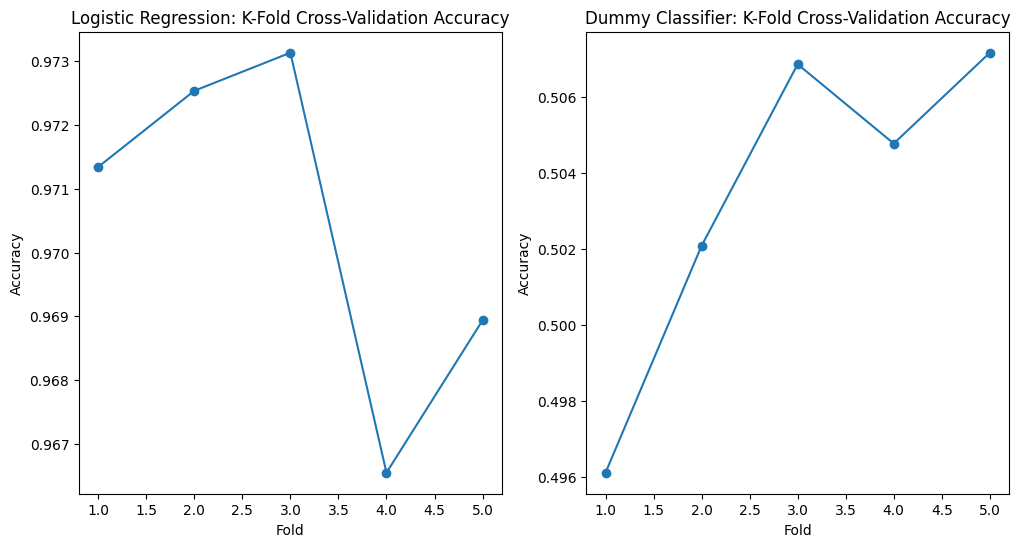

Average Accuracy: 0.9704997592681751
Average Precision: 0.9954861445479406
Average Recall: 0.9346007187574064
Average F1-score: 0.9640804997240272
Dummy Average Accuracy: 0.5034044116335884
Dummy Average Precision: 0.4267271804977816
Dummy Average Recall: 0.5002579736637375
Dummy Average F1-score: 0.460330679753641


In [ ]:
data = load_data(file_path)  # Load data through the utility function defined above

# Set retrain_on_full_data to True to retrain on the full dataset
# Here "avg_accuracy", "avg_precision", "avg_recall", "avg_f1" corresponds to the trained Logistic Regression Classifier, "model" is the trained model,
# Here "dm_avg_accuracy", "dm_avg_precision", "dm_avg_recall", "dm_avg_f1" corresponds to the Baseline model, which is a "Dummy Classifier" that randomly chooses an example to be the class "Ham" or "Spam"
# Here the "k_fold_cross_validation" is the function where we train the Logistic Regression model in the K-fold cross validation setup

avg_accuracy, avg_precision, avg_recall, avg_f1, tfidf, model, label_encoder, dm_avg_accuracy, dm_avg_precision, dm_avg_recall, dm_avg_f1 = k_fold_cross_validation(data, k=5, retrain_on_full_data=False)
print("Average Accuracy:", avg_accuracy)
print("Average Precision:", avg_precision)
print("Average Recall:", avg_recall)
print("Average F1-score:", avg_f1)

print("Dummy Average Accuracy:", dm_avg_accuracy)
print("Dummy Average Precision:", dm_avg_precision)
print("Dummy Average Recall:", dm_avg_recall)
print("Dummy Average F1-score:", dm_avg_f1)

In [ ]:
### Human Generated Spam emails

# XXXMobileMovieClub: To use your credit, click the WAP link in the next txt message or click here>> http://wap. xxxmobilemovieclub.com?n=QJKGIGHJJGCBL

# England v Macedonia - dont miss the goals/team news. Txt ur national team to 87077 eg ENGLAND to 87077 Try:WALES, SCOTLAND 4txt/ú1.20 POBOXox36504W45WQ 16+

# Thanks for your subscription to Ringtone UK your mobile will be charged £5/month Please confirm by replying YES or NO. If you reply NO you will not be charged

# 07732584351 - Rodger Burns - MSG = We tried to call you re your reply to our sms for a free nokia mobile + free camcorder. Please call now 08000930705 for delivery tomorrow

In [ ]:
# Example of inference with human generated data
new_texts = ["SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info", "URGENT! You have won a 1 week FREE membership in our £100,000 Prize Jackpot! Txt the word: CLAIM to No: 81010 T&C www.dbuk.net LCCLTD POBOX 4403LDNW1A7RW18"]
predictions = inference(tfidf, model, label_encoder, new_texts)
print("Predictions:", predictions)

Predictions: ['spam' 'spam']


In [ ]:
### LLM generated Spam emails

# "Subject: Claim Your $10,000 Jackpot Today! Dear valued customer, We are delighted to inform you that you have won a grand prize of $10,000 in our latest jackpot draw! This amazing news is a result of your recent participation in our sweepstakes promotion. To claim your winnings, kindly click the link below and provide the necessary information: https://www.fakewebsite.com/claim-prize.php Please be advised that this offer is only valid for a limited time, so act fast to avoid missing out on this life-changing opportunity. We wish you all the best in your future endeavors and look forward to your continued business with us. Best regards,"

# "Subject: Claim your $10,000 inheritance today! Dear valued customer, We are excited to inform you that you have been selected to receive a generous inheritance worth $10,000! This fortune comes as a result of a recent estate settlement, and you are among the lucky few who have been chosen to receive a share. To claim your inheritance, simply follow the instructions below: 1. Click the link below to verify your identity and eligibility: 2. Provide us with your personal and banking information to facilitate the transfer of funds: 3. Once we receive your information, your inheritance will be transferred to your bank account within 48 hours. But hurry! This offer is only valid for the next 72 hours. Don't miss out on this life-changing opportunity! Best regards, The Inheritance Team"

In [ ]:
# Example of inference with llm generated new data
new_texts = ["Subject: Claim Your $10,000 Jackpot Today! Dear valued customer, We are delighted to inform you that you have won a grand prize of $10,000 in our latest jackpot draw! This amazing news is a result of your recent participation in our sweepstakes promotion. To claim your winnings, kindly click the link below and provide the necessary information: https://www.fakewebsite.com/claim-prize.php Please be advised that this offer is only valid for a limited time, so act fast to avoid missing out on this life-changing opportunity. We wish you all the best in your future endeavors and look forward to your continued business with us. Best regards,", "Subject: Claim your $10,000 inheritance today! Dear valued customer, We are excited to inform you that you have been selected to receive a generous inheritance worth $10,000! This fortune comes as a result of a recent estate settlement, and you are among the lucky few who have been chosen to receive a share. To claim your inheritance, simply follow the instructions below: 1. Click the link below to verify your identity and eligibility: 2. Provide us with your personal and banking information to facilitate the transfer of funds: 3. Once we receive your information, your inheritance will be transferred to your bank account within 48 hours. But hurry! This offer is only valid for the next 72 hours. Don't miss out on this life-changing opportunity! Best regards, The Inheritance Team"]
predictions = inference(tfidf, model, label_encoder, new_texts)
print("Predictions:", predictions)

Predictions: ['spam' 'spam']


### Results

In [ ]:
test = pd.read_csv("/content/combined_test.csv") # Read from test dataset
test.head()

In [ ]:
test["label_num"] = test["label"]
test["label_num"].replace({"ham": 0, "spam": 1}, inplace=True)

In [ ]:
test.label.value_counts()

ham     3672
spam    1499
Name: label, dtype: int64

In [ ]:
test["text"] = test.text.apply(preprocess_text)
test_inputs_feature_extraction = tfidf.transform(test["text"])
input_prediction = model.predict(test_inputs_feature_extraction)

print(input_prediction)

In [ ]:
accuracy_on_input = accuracy_score(test.label_num.values, input_prediction)
precision_on_input = precision_score(test.label_num.values, input_prediction)
recall_on_input = recall_score(test.label_num.values, input_prediction)
f1score_on_input = f1_score(test.label_num.values, input_prediction)
print("accuracy_on_input: " , accuracy_on_input)
print("precision_on_input: " , precision_on_input)
print("recall_on_input: " , recall_on_input)
print("f1score_on_input: " , f1score_on_input)